# Sentiment analysis with a transformer encoder.

This notebook contains code that demonstrates how to build a transformer encoder from scratch for binary sentiment classification.

In [109]:
import pandas as pd
import numpy as np
import emoji
import string
from bs4 import BeautifulSoup
import re
import nltk
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


# DATA
DATA = pd.read_csv('data/go_emotions_dataset.csv')
CATEGORIES = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise']
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
TEXT = 'text'
TOTAL_SIZE = len(DATA)
# CONFIGURATION
TRAIN_SIZE = int(TOTAL_SIZE*0.8)
VAL_SIZE = int(TOTAL_SIZE*0.1)
TEST_SIZE = int(TOTAL_SIZE*0.1)

TRAIN_DATA = DATA[:TRAIN_SIZE]


VAL_DATA = DATA[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]

TEST_DATA = DATA[TRAIN_SIZE+VAL_SIZE:]

print(f"Train size: {len(TRAIN_DATA)}")
print(f"Val size: {len(VAL_DATA)}")
print(f"Test size: {len(TEST_DATA)}")

# MODEL PARAMS
BATCH_SIZE=32
VOCAB_SIZE=10000
SEQUENCE_LENGTH=128
EMBEDDING_DIM=100
D_FF=1024
NUM_HEADS=12
NUM_LAYERS=1
NUM_EPOCHS=20
CONV_KERNEL_SIZE = 5
N_FILTERS = 32  


Train size: 56980
Val size: 7122
Test size: 7123


In [110]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

PUNCT = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}
MISPELL_DICT = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, CONTRACTION_MAPPING)
    text = clean_special_chars(text, PUNCT, PUNCT_MAPPING)
    text = correct_spelling(text, MISPELL_DICT)
    text = remove_space(text)
    return text

## 1. Data loading.

In [111]:
def load_and_split_data(data):
    text = data[TEXT].apply(text_preprocessing_pipeline).values
    label = data[CATEGORIES].values.astype("float32")
    return text, label

# Load the data
print("Loading data...")
train_data, train_labels = load_and_split_data(TRAIN_DATA)
val_data, val_labels = load_and_split_data(VAL_DATA)
test_data, test_labels = load_and_split_data(TEST_DATA)

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

print("Data loaded successfully!")

Loading data...


c:\Users\raulm\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\Users\raulm\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: ". ." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\Users\raulm\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: ". " looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
c:\Users\raulm\anaconda3\envs\tensorflow\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: "/" looks like a directory name

Data loaded successfully!


## 2. Data preprocessing.

In [112]:

def standardization(input_data):
    input_data = tf.strings.lower(input_data)
    input_data = tf.strings.regex_replace(input_data, r'\d+', '')
    input_data = tf.strings.regex_replace(input_data, r'[^\w\s]', '')
    input_data = tf.strings.strip(input_data)
    return input_data






In [113]:
vectorize_layer=tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=SEQUENCE_LENGTH
)


In [114]:
training_dataset = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(training_dataset)


In [115]:
def vectorizer(review,label):
    review =  vectorize_layer(review)
    if len(review)<SEQUENCE_LENGTH:
        review = tf.pad(review, [[0,SEQUENCE_LENGTH-len(review)]])
    return review,label

In [116]:
import pickle
with open('models/vectorize_layer.h5', 'wb') as f:
    pickle.dump({'weights':vectorize_layer.get_weights(), 'config': vectorize_layer.get_config()}, f)

In [117]:
train_dataset=train_dataset.map(vectorizer)
val_dataset=val_dataset.map(vectorizer)
test_dataset=test_dataset.map(vectorizer)



In [118]:
train_dataset=train_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

## 3. Data modelling
### 3.1. Embedding layer.

In [119]:
import numpy as np
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [120]:
class Embeddings(tf.keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=tf.keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config

### 3.2 Encoder layer.

In [127]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        

        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1, 
        )
        self.dense_proj=tf.keras.Sequential(
            [tf.keras.layers.Dense(dense_dim, activation="elu"),tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      
     
      
      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

 
      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)

      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

### 3. Final model.

In [129]:
encoder_input=tf.keras.layers.Input(shape=(None,), dtype="int32", name="input")

x = Embeddings(SEQUENCE_LENGTH,VOCAB_SIZE,EMBEDDING_DIM)(encoder_input)

for _ in range(NUM_LAYERS):
  
  x=TransformerEncoder(EMBEDDING_DIM,D_FF,NUM_HEADS)(x)

x = tf.keras.layers.Flatten()(x)
output=tf.keras.layers.Dense(len(CATEGORIES), activation="sigmoid")(x)

transformer = tf.keras.Model(
    encoder_input, output, name="transformer"
)
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embeddings_18 (Embeddings)   (None, 128, 100)          1000000   
_________________________________________________________________
transformer_encoder_19 (Tran (None, 128, 100)          690024    
_________________________________________________________________
transformer_encoder_20 (Tran (None, 128, 100)          690024    
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 27)                345627    
Total params: 2,725,675
Trainable params: 2,725,675
Non-trainable params: 0
_____________________________________________

In [123]:
checkpoint_filepath = 'models/transformer.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)

In [131]:

transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'),
              metrics=['accuracy', 'AUC'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6))


### 4. Model training.

In [132]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=NUM_EPOCHS,
    callbacks=[model_checkpoint_callback, reduce_lr])

Epoch 1/20
890/890 [==============================] - 111s 122ms/step - loss: 0.1467 - accuracy: 0.1602 - auc: 0.6509 - val_loss: 0.1444 - val_accuracy: 0.0610 - val_auc: 0.6592
Epoch 2/20
890/890 [==============================] - 107s 120ms/step - loss: 0.1427 - accuracy: 0.1680 - auc: 0.6699 - val_loss: 0.1415 - val_accuracy: 0.1340 - val_auc: 0.6743
Epoch 3/20
890/890 [==============================] - 106s 119ms/step - loss: 0.1335 - accuracy: 0.1977 - auc: 0.7307 - val_loss: 0.1280 - val_accuracy: 0.1838 - val_auc: 0.7676
Epoch 4/20
890/890 [==============================] - 108s 121ms/step - loss: 0.1225 - accuracy: 0.2336 - auc: 0.8006 - val_loss: 0.1223 - val_accuracy: 0.2549 - val_auc: 0.8009
Epoch 5/20
890/890 [==============================] - 109s 122ms/step - loss: 0.1153 - accuracy: 0.2685 - auc: 0.8361 - val_loss: 0.1192 - val_accuracy: 0.2789 - val_auc: 0.8183
Epoch 6/20
890/890 [==============================] - 108s 121ms/step - loss: 0.1100 - accuracy: 0.2898 - auc:

### 5. Accuracy evolution.

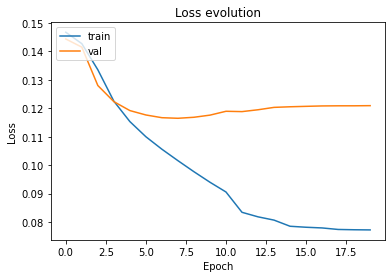

In [133]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

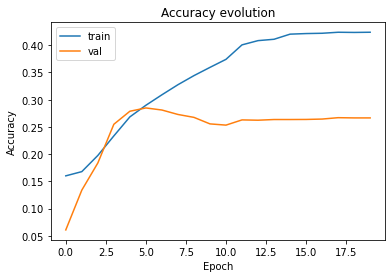

In [134]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [135]:
evaluation = transformer.evaluate(test_dataset.batch(1))
print("Done")
print(f"Final loss: {evaluation[0]}")
print(f"Final accuracy: {evaluation[1]}")

7123/7123 [==============================] - 44s 6ms/step - loss: 0.1219 - accuracy: 0.2639 - auc: 0.8292
Done
Final loss: 0.1218886449933052
Final accuracy: 0.2639337480068207


([<matplotlib.axis.XTick at 0x1651322ca90>,
 [Text(0, 0, 'admiration'),
  Text(1, 0, 'amusement'),
  Text(2, 0, 'anger'),
  Text(3, 0, 'annoyance'),
  Text(4, 0, 'approval'),
  Text(5, 0, 'caring'),
  Text(6, 0, 'confusion'),
  Text(7, 0, 'curiosity'),
  Text(8, 0, 'desire'),
  Text(9, 0, 'disappointment'),
  Text(10, 0, 'disapproval'),
  Text(11, 0, 'disgust'),
  Text(12, 0, 'embarrassment'),
  Text(13, 0, 'excitement'),
  Text(14, 0, 'fear'),
  Text(15, 0, 'gratitude'),
  Text(16, 0, 'grief'),
  Text(17, 0, 'joy'),
  Text(18, 0, 'love'),
  Text(19, 0, 'nervousness'),
  Text(20, 0, 'optimism'),
  Text(21, 0, 'pride'),
  Text(22, 0, 'realization'),
  Text(23, 0, 'relief'),
  Text(24, 0, 'remorse'),
  Text(25, 0, 'sadness'),
  Text(26, 0, 'surprise')])

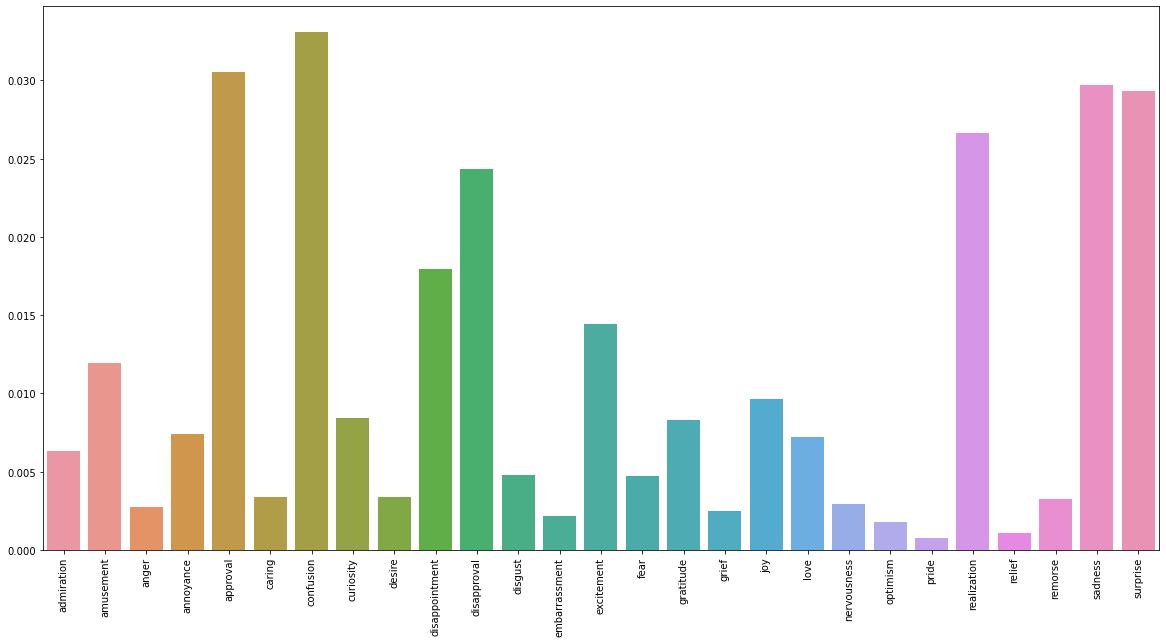

In [136]:
import seaborn as sns
text = "I am happy."
text, label = vectorizer(text, [0]*28)
prediction = transformer.predict(text)
plt.figure(figsize=(20,10))
sns.barplot(x=CATEGORIES, y=prediction[0])
plt.xticks(plt.gca().get_xticks(), rotation=90)



